## Analytics Vidya Cross Sell Prediction

https://datahack.analyticsvidhya.com/contest/janatahack-cross-sell-prediction/#ProblemStatement

### Import Necessary Libraries

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek,SMOTEENN
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.svm import SVC

### Import Data

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
sample_df = pd.read_csv('sample_submission_iA3afxn.csv')

In [3]:
train_data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


### EDA

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


<AxesSubplot:xlabel='Gender', ylabel='count'>

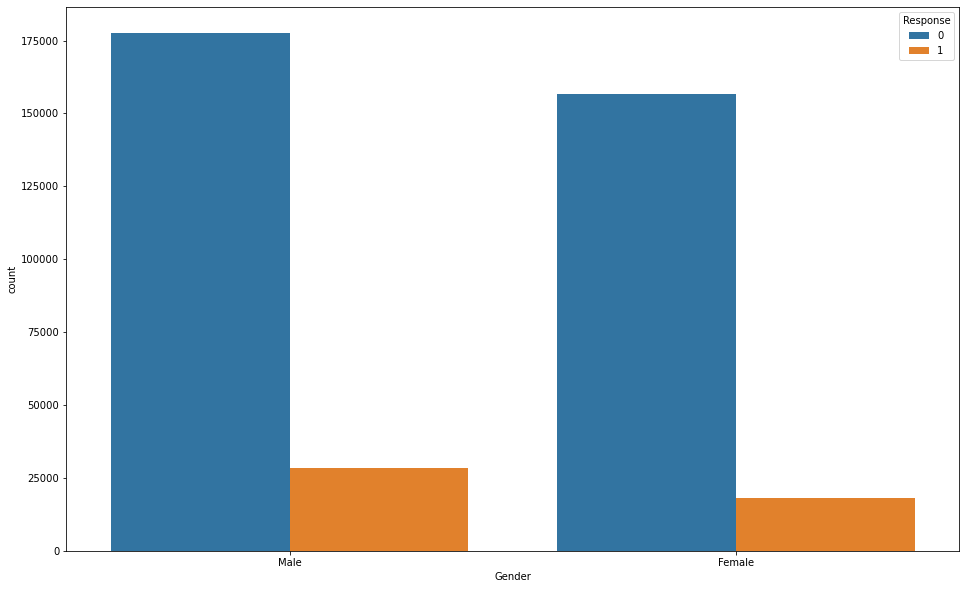

In [28]:
plt.figure(figsize=(16,10))
sns.countplot(x=train_data['Gender'], hue=train_data['Response'])

In [3]:
def percent_cat(col):
    groupped = train_data.groupby([col])['Response'].value_counts()
    y=0
    for i in groupped.index:
        total_val = len(train_data[train_data[col]==i[0]])
        print(f'Percent of Customers chance of {i[1]} insurance for {i[0]} in column {col} is {round((groupped[i]/total_val)*100,2)}%')
        y+=1
        if y==2:
            print('\n')
            y=0

In [156]:
percent_cat('Gender')

Percent of Customers chance of 0 insurance for Female in column Gender is 89.61%
Percent of Customers chance of 1 insurance for Female in column Gender is 10.39%


Percent of Customers chance of 0 insurance for Male in column Gender is 86.16%
Percent of Customers chance of 1 insurance for Male in column Gender is 13.84%




**Observations**:
* There is higher chance of female customers not taking insurance compared to male customers

<AxesSubplot:xlabel='Age', ylabel='Count'>

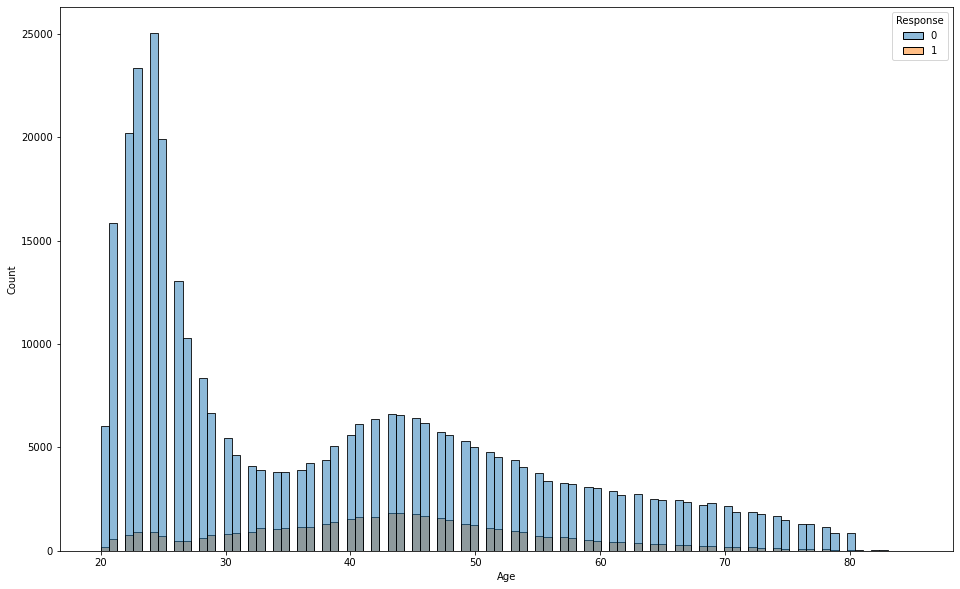

In [23]:
plt.figure(figsize=(16,10))
sns.histplot(x=train_data['Age'], hue=train_data['Response'])


In [25]:
train_data['Region_Code'].nunique()

53

In [27]:
train_data['Region_Code'].value_counts()

28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       4038
13.0      4036
7.0       3279
12.0      3198
9.0       3101
27.0      2823
32.0      2787
43.0      2639
17.0      2617
26.0      2587
25.0      2503
24.0      2415
38.0      2026
0.0       2021
16.0      2007
31.0      1960
23.0      1960
20.0      1935
49.0      1832
4.0       1801
34.0      1664
19.0      1535
22.0      1309
40.0      1295
5.0       1279
1.0       1008
44.0       808
42.0       591
52.0       267
51.0       183
Name: Region_Code, dtype: int64

<AxesSubplot:xlabel='Previously_Insured', ylabel='count'>

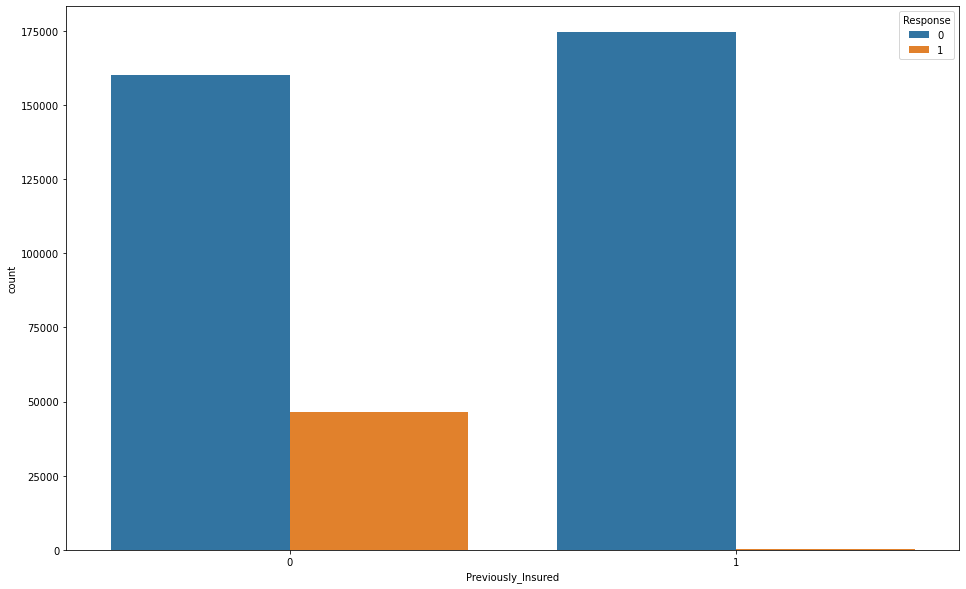

In [29]:
plt.figure(figsize=(16,10))
sns.countplot(x=train_data['Previously_Insured'], hue=train_data['Response'])

In [30]:
percent_cat('Previously_Insured')

Percent of Customers chance of 0 insurance for 0 in column Previously_Insured is 77.45%
Percent of Customers chance of 1 insurance for 0 in column Previously_Insured is 22.55%


Percent of Customers chance of 0 insurance for 1 in column Previously_Insured is 99.91%
Percent of Customers chance of 1 insurance for 1 in column Previously_Insured is 0.09%




**Observation**:
* Majority of Customers who have previously insured don't take insurance next time.
* Insurance have taken mostly by new customers.

In [31]:
train_data['Vehicle_Age'].value_counts()

1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64

<AxesSubplot:xlabel='Vehicle_Age', ylabel='count'>

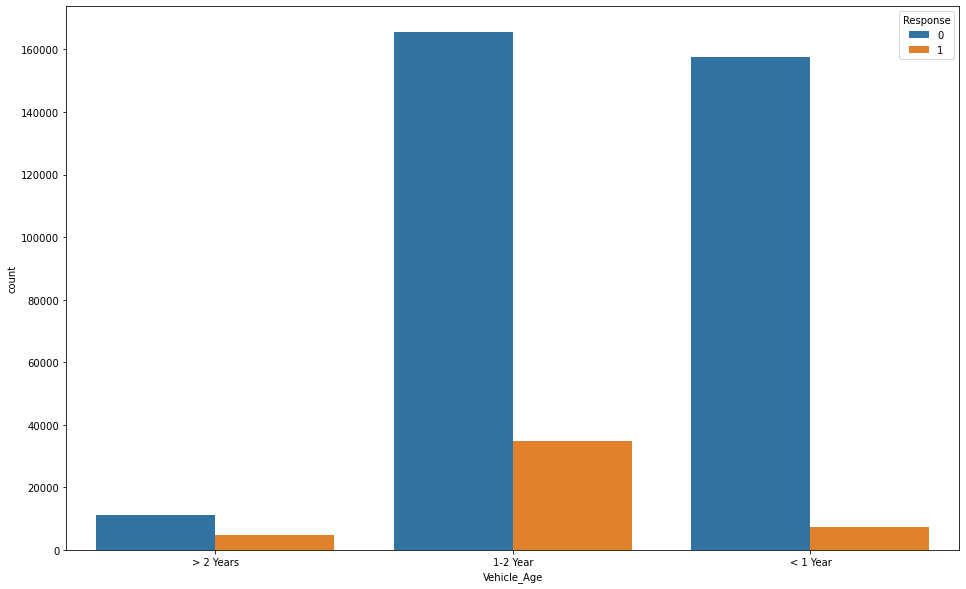

In [32]:
plt.figure(figsize=(16,10))
sns.countplot(x=train_data['Vehicle_Age'], hue=train_data['Response'])

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Annual_Premium', ylabel='Density'>

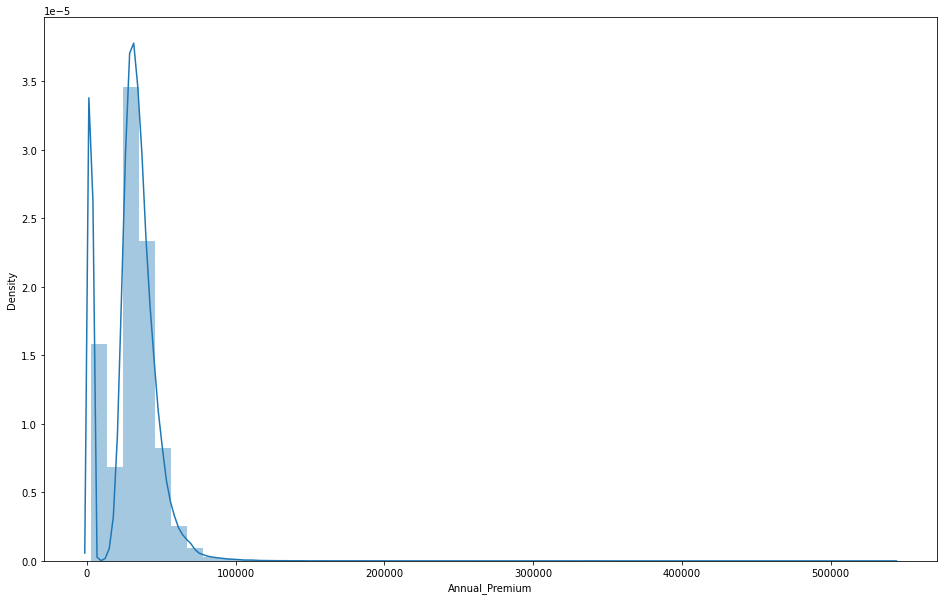

In [67]:
plt.figure(figsize=(16,10))
sns.distplot(train_data['Annual_Premium'])

In [33]:
percent_cat('Vehicle_Age')

Percent of Customers chance of 0 insurance for 1-2 Year in column Vehicle_Age is 82.62%
Percent of Customers chance of 1 insurance for 1-2 Year in column Vehicle_Age is 17.38%


Percent of Customers chance of 0 insurance for < 1 Year in column Vehicle_Age is 95.63%
Percent of Customers chance of 1 insurance for < 1 Year in column Vehicle_Age is 4.37%


Percent of Customers chance of 0 insurance for > 2 Years in column Vehicle_Age is 70.63%
Percent of Customers chance of 1 insurance for > 2 Years in column Vehicle_Age is 29.37%




**Observation**:
* Customers are instersted in insurance whose vehicle age is more than 2 years.

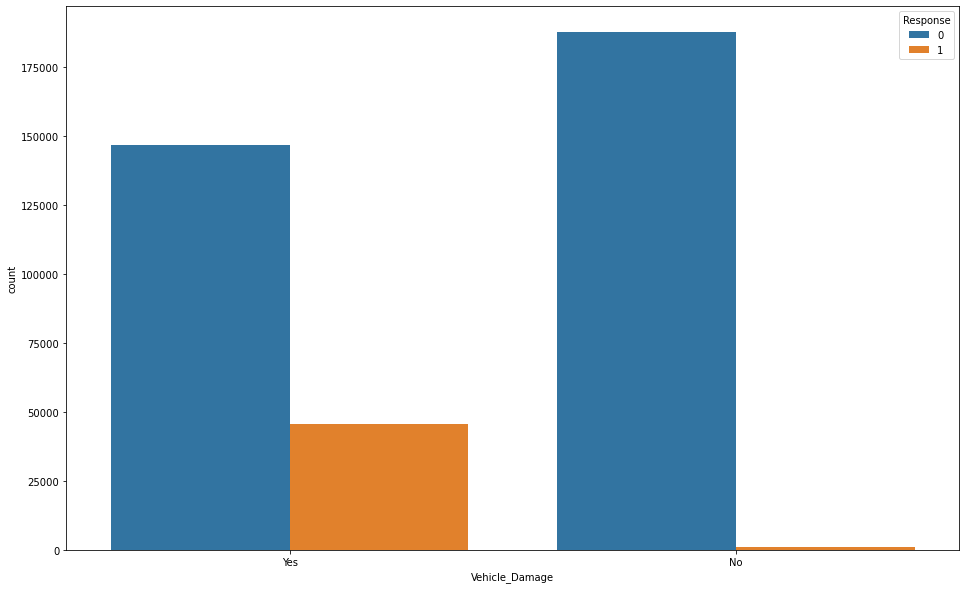

In [36]:
plt.figure(figsize=(16,10))
sns.countplot(x=train_data['Vehicle_Damage'], hue=train_data['Response']);

In [37]:
percent_cat('Vehicle_Damage')

Percent of Customers chance of 0 insurance for No in column Vehicle_Damage is 99.48%
Percent of Customers chance of 1 insurance for No in column Vehicle_Damage is 0.52%


Percent of Customers chance of 0 insurance for Yes in column Vehicle_Damage is 76.23%
Percent of Customers chance of 1 insurance for Yes in column Vehicle_Damage is 23.77%




**Observation**:
* Customers got his/her vehicle damaged in the past have showed more interest in taking insurance, whereas the customers who didn't get his/her vehicle damaged have showed less interest towards insurance.

In [40]:
train_data['Annual_Premium'].nunique()

48838

In [49]:
train_data['Policy_Sales_Channel'].value_counts()

152.0    134784
26.0      79700
124.0     73995
160.0     21779
156.0     10661
          ...  
149.0         1
143.0         1
43.0          1
41.0          1
84.0          1
Name: Policy_Sales_Channel, Length: 155, dtype: int64

In [51]:
train_data['Vintage'].value_counts()

256    1418
73     1410
282    1397
158    1394
187    1392
       ... 
205    1235
89     1234
32     1230
224    1227
277    1226
Name: Vintage, Length: 290, dtype: int64

In [52]:
train_data['Response'].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

### Feature Engineering

In [4]:
train_data['Age'].describe()

count    381109.000000
mean         38.822584
std          15.511611
min          20.000000
25%          25.000000
50%          36.000000
75%          49.000000
max          85.000000
Name: Age, dtype: float64

In [5]:
def age_cat(i):
    if i < 35:
        return 0
    elif i<60:
        return 1
    else :
        return 2 

In [6]:
train_data['Age_bin'] = train_data['Age'].apply(age_cat)
test_data['Age_bin'] = test_data['Age'].apply(age_cat)

In [160]:
percent_cat('Age_bin')

Percent of Customers chance of 0 insurance for 0 in column Age_bin is 93.88%
Percent of Customers chance of 1 insurance for 0 in column Age_bin is 6.12%


Percent of Customers chance of 0 insurance for 1 in column Age_bin is 79.72%
Percent of Customers chance of 1 insurance for 1 in column Age_bin is 20.28%


Percent of Customers chance of 0 insurance for 2 in column Age_bin is 90.03%
Percent of Customers chance of 1 insurance for 2 in column Age_bin is 9.97%




<AxesSubplot:xlabel='Age_bin', ylabel='count'>

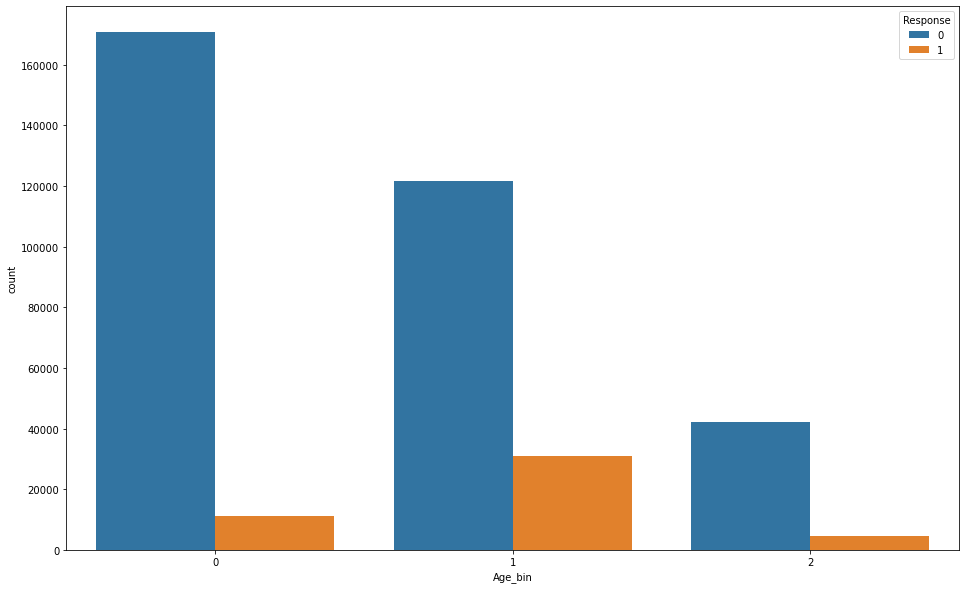

In [161]:
plt.figure(figsize=(16,10))
sns.countplot(x=train_data['Age_bin'], hue=train_data['Response'])

In [7]:
train_data['Annual_Premium'].describe()

count    381109.000000
mean      30564.389581
std       17213.155057
min        2630.000000
25%       24405.000000
50%       31669.000000
75%       39400.000000
max      540165.000000
Name: Annual_Premium, dtype: float64

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Annual_Premium', ylabel='Density'>

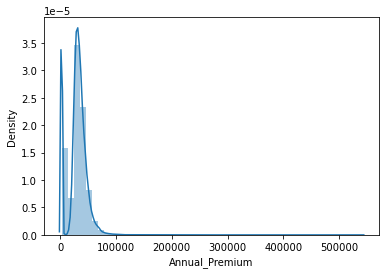

In [8]:
sns.distplot(train_data['Annual_Premium'])

#### Encoding

In [9]:
train_df = train_data.copy()
test_df = test_data.copy()

In [10]:
cat_types = train_data.select_dtypes(exclude=np.number).columns
cat_types

Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')

In [11]:
le =LabelEncoder()
def encode(df,col):
    le.fit(train_data[col])
    df[col]=le.transform(df[col])

In [12]:
sc = StandardScaler()
def scaling (df):
    sc.fit(train_df.drop('Response',axis=1))
    df_sc = pd.DataFrame(sc.transform(df),columns=df.columns)
    return df_sc

In [13]:
train_df['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [14]:
cat_types

Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')

In [15]:
for i in cat_types:
    encode(train_df,i)

In [16]:
for i in cat_types:
    encode(test_df,i)

In [17]:
train_one = pd.get_dummies(train_data,columns=cat_types)
test_one = pd.get_dummies(test_data,columns=cat_types)

In [18]:
train_one.columns

Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response',
       'Age_bin', 'Gender_Female', 'Gender_Male', 'Vehicle_Age_1-2 Year',
       'Vehicle_Age_< 1 Year', 'Vehicle_Age_> 2 Years', 'Vehicle_Damage_No',
       'Vehicle_Damage_Yes'],
      dtype='object')

In [19]:
train_one.drop('id',axis=1,inplace=True)
test_one.drop('id',axis=1,inplace=True)

In [20]:
train_df_sc = scaling(train_df.drop('Response',axis=1))
test_df_sc = scaling(test_df)

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  int64  
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  int64  
 7   Vehicle_Damage        381109 non-null  int64  
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
 12  Age_bin               381109 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 37.8 MB


In [22]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    127037 non-null  int64  
 1   Gender                127037 non-null  int64  
 2   Age                   127037 non-null  int64  
 3   Driving_License       127037 non-null  int64  
 4   Region_Code           127037 non-null  float64
 5   Previously_Insured    127037 non-null  int64  
 6   Vehicle_Age           127037 non-null  int64  
 7   Vehicle_Damage        127037 non-null  int64  
 8   Annual_Premium        127037 non-null  float64
 9   Policy_Sales_Channel  127037 non-null  float64
 10  Vintage               127037 non-null  int64  
 11  Age_bin               127037 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 11.6 MB


In [23]:
train_df.drop('id',axis=1,inplace=True)
test_df.drop('id',axis=1,inplace=True)

In [24]:
train_df.drop('Age',axis=1,inplace=True)
test_df.drop('Age',axis=1,inplace=True)

In [25]:
train_df

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Age_bin
0,1,1,28.0,0,2,1,40454.0,26.0,217,1,1
1,1,1,3.0,0,0,0,33536.0,26.0,183,0,2
2,1,1,28.0,0,2,1,38294.0,26.0,27,1,1
3,1,1,11.0,1,1,0,28619.0,152.0,203,0,0
4,0,1,41.0,1,1,0,27496.0,152.0,39,0,0
...,...,...,...,...,...,...,...,...,...,...,...
381104,1,1,26.0,1,0,0,30170.0,26.0,88,0,2
381105,1,1,37.0,1,1,0,40016.0,152.0,131,0,0
381106,1,1,30.0,1,1,0,35118.0,160.0,161,0,0
381107,0,1,14.0,0,2,1,44617.0,124.0,74,0,2


In [27]:
#train_df.drop('Annual_bin',axis=1,inplace=True)
#test_df.drop('Annual_bin',axis=1,inplace=True)

In [28]:
train_df

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Age_bin
0,1,1,28.0,0,2,1,40454.0,26.0,217,1,1
1,1,1,3.0,0,0,0,33536.0,26.0,183,0,2
2,1,1,28.0,0,2,1,38294.0,26.0,27,1,1
3,1,1,11.0,1,1,0,28619.0,152.0,203,0,0
4,0,1,41.0,1,1,0,27496.0,152.0,39,0,0
...,...,...,...,...,...,...,...,...,...,...,...
381104,1,1,26.0,1,0,0,30170.0,26.0,88,0,2
381105,1,1,37.0,1,1,0,40016.0,152.0,131,0,0
381106,1,1,30.0,1,1,0,35118.0,160.0,161,0,0
381107,0,1,14.0,0,2,1,44617.0,124.0,74,0,2


In [29]:
X = train_df.drop('Response', axis =1)
y = train_df['Response']

In [30]:
X_o = train_one.drop('Response', axis=1)
y_o = train_one['Response']

In [31]:
X_sc = train_df_sc
y_sc = train_df['Response']

In [20]:
X_o.head()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,Vehicle_Damage_Yes
0,44,1,28.0,0,40454.0,26.0,217,0,1,0,0,1,0,1
1,76,1,3.0,0,33536.0,26.0,183,0,1,1,0,0,1,0
2,47,1,28.0,0,38294.0,26.0,27,0,1,0,0,1,0,1
3,21,1,11.0,1,28619.0,152.0,203,0,1,0,1,0,1,0
4,29,1,41.0,1,27496.0,152.0,39,1,0,0,1,0,1,0


#### Splitting

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [33]:
#One hot encoded 
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_o, y_o, test_size=0.3, random_state=100)

In [34]:
#Standard sclar
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_sc, y_sc, test_size=0.3, random_state=100)

In [35]:
y_train_sc.value_counts()

0    233977
1     32799
Name: Response, dtype: int64

In [276]:
X_train_o.head()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,Vehicle_Damage_Yes
262790,39,1,8.0,0,51283.0,26.0,175,0,1,1,0,0,0,1
244532,52,1,0.0,0,36534.0,124.0,64,0,1,0,0,1,0,1
48688,65,1,9.0,0,30932.0,156.0,84,0,1,0,0,1,0,1
61641,30,1,46.0,1,41419.0,152.0,181,1,0,0,1,0,1,0
352835,70,1,28.0,1,31598.0,26.0,137,0,1,1,0,0,1,0


#### SMOTE

In [36]:
sm = SMOTE()

In [37]:
X_train_sm,y_train_sm = sm.fit_resample(X_train,y_train)

In [329]:
print('Before SMOTE:',y_train.value_counts())
print('After SMOTE:',y_train_sm.value_counts())

Before SMOTE: 0    233977
1     32799
Name: Response, dtype: int64
After SMOTE: 0    233977
1    233977
Name: Response, dtype: int64


In [38]:
X_full_sm,y_full_sm = sm.fit_resample(X,y)

In [39]:
print('Before SMOTE:',y.value_counts())
print('After SMOTE:',y_full_sm.value_counts())

Before SMOTE: 0    334399
1     46710
Name: Response, dtype: int64
After SMOTE: 0    334399
1    334399
Name: Response, dtype: int64


In [332]:
X_full_sm.drop('Annual_bin',axis=1,inplace=True)

KeyError: "['Annual_bin'] not found in axis"

#### Modelling

In [333]:
X_full_sm

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Age_bin
0,1,1,28.000000,0,2,1,40454.000000,26.000000,217,1
1,1,1,3.000000,0,0,0,33536.000000,26.000000,183,2
2,1,1,28.000000,0,2,1,38294.000000,26.000000,27,1
3,1,1,11.000000,1,1,0,28619.000000,152.000000,203,0
4,0,1,41.000000,1,1,0,27496.000000,152.000000,39,0
...,...,...,...,...,...,...,...,...,...,...
668793,1,1,21.923985,0,1,1,38496.589064,153.258906,93,0
668794,1,1,25.989864,0,1,0,48654.296453,24.090371,140,1
668795,1,1,28.855395,0,0,1,32531.213849,124.000000,15,0
668796,1,1,47.950944,0,0,1,46474.024528,154.720583,69,0


In [334]:
test_df

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Age_bin
0,1,1,11.0,1,1,0,35786.0,152.0,53,0
1,1,1,28.0,0,0,1,33762.0,7.0,111,1
2,1,1,28.0,0,0,1,40050.0,124.0,199,1
3,1,1,27.0,1,1,1,37356.0,152.0,187,0
4,1,1,28.0,1,1,0,59097.0,152.0,297,0
...,...,...,...,...,...,...,...,...,...,...
127032,0,1,37.0,1,1,0,30867.0,152.0,56,0
127033,0,1,28.0,0,0,1,28700.0,122.0,165,1
127034,1,1,46.0,1,1,0,29802.0,152.0,74,0
127035,1,1,28.0,1,0,0,62875.0,26.0,265,2


In [40]:
def metrics(y_true,y_pred):
    print('Confusion Matrix:\n', confusion_matrix(y_true, y_pred))
    print('\n\nAccuracy Score:\n', accuracy_score(y_true, y_pred))
    print('\n\nClassification Report: \n', classification_report(y_true, y_pred))

def prediction(model,val='no',X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, test=test_df,X_full=X_full_sm,y_full=y_full_sm ):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    actual = [y_train, y_test]
    pred = [train_pred, test_pred]
    sam = ['Train','Test']
   
    for i in range(2):
        print(sam[i]+' Metrics\n')
        metrics(actual[i],pred[i])
    if val=='o':
        X = pd.concat([X_train,X_test]).sort_index()
        y = pd.concat([y_train, y_test]).sort_index()
        model.fit(X,y)
        finalpred = model.predict(test)
        sample_df['Response'] = finalpred
        sample_df.to_csv(str(model)[:10]+'Pred.csv',index=False)
        print('Done')
    elif val == 's':
        model.fit(X_full_sm,y_full_sm)
        finalpred = model.predict(test)
        sample_df['Response'] = finalpred
        sample_df.to_csv(str(model)[:10]+'SMOTEPred.csv',index=False)
        print('Smote done')
    else:
        pass
        #print(str(model)+'pred.csv','Done')
        #return sample_df

### Logistic Regression

In [41]:
lg = LogisticRegression(max_iter=2000)

In [140]:
prediction(lg,val='o')

Train Metrics

Confusion Matrix:
 [[233052    925]
 [ 32378    421]]


Accuracy Score:
 0.8751649323777251


Classification Report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.93    233977
           1       0.31      0.01      0.02     32799

    accuracy                           0.88    266776
   macro avg       0.60      0.50      0.48    266776
weighted avg       0.81      0.88      0.82    266776

Test Metrics

Confusion Matrix:
 [[100035    387]
 [ 13732    179]]


Accuracy Score:
 0.8765098440520235


Classification Report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.93    100422
           1       0.32      0.01      0.02     13911

    accuracy                           0.88    114333
   macro avg       0.60      0.50      0.48    114333
weighted avg       0.81      0.88      0.82    114333

Done


In [305]:
X_train

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Age_bin,Annual_bin
262790,1,1,8.0,0,0,1,51283.0,26.0,175,1,2
244532,1,1,0.0,0,2,1,36534.0,124.0,64,1,2
48688,1,1,9.0,0,2,1,30932.0,156.0,84,2,1
61641,0,1,46.0,1,1,0,41419.0,152.0,181,0,2
352835,1,1,28.0,1,0,0,31598.0,26.0,137,2,1
...,...,...,...,...,...,...,...,...,...,...,...
339799,0,1,28.0,0,0,1,26954.0,26.0,110,1,1
253799,0,1,47.0,0,1,1,25686.0,160.0,268,0,1
210755,0,1,28.0,0,0,1,26076.0,124.0,93,1,1
56088,1,1,28.0,1,0,0,60422.0,124.0,82,1,2


In [310]:
prediction(lg,X_train=X_train_sm, y_train=y_train_sm)

Train Metrics

Confusion Matrix:
 [[161617  72360]
 [ 25974 208003]]


Accuracy Score:
 0.7898639609876185


Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.69      0.77    233977
           1       0.74      0.89      0.81    233977

    accuracy                           0.79    467954
   macro avg       0.80      0.79      0.79    467954
weighted avg       0.80      0.79      0.79    467954

Test Metrics

Confusion Matrix:
 [[69405 31017]
 [ 2950 10961]]


Accuracy Score:
 0.7029116702964149


Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.69      0.80    100422
           1       0.26      0.79      0.39     13911

    accuracy                           0.70    114333
   macro avg       0.61      0.74      0.60    114333
weighted avg       0.87      0.70      0.75    114333



In [275]:
prediction(lg,X_train_o, X_test_o, y_train_o, y_test_o)#One hot encoded data

Train Metrics

Confusion Matrix:
 [[233503    474]
 [ 32599    200]]


Accuracy Score:
 0.876027078897652


Classification Report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.93    233977
           1       0.30      0.01      0.01     32799

    accuracy                           0.88    266776
   macro avg       0.59      0.50      0.47    266776
weighted avg       0.81      0.88      0.82    266776

Test Metrics

Confusion Matrix:
 [[100222    200]
 [ 13817     94]]


Accuracy Score:
 0.8774019749328715


Classification Report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.93    100422
           1       0.32      0.01      0.01     13911

    accuracy                           0.88    114333
   macro avg       0.60      0.50      0.47    114333
weighted avg       0.81      0.88      0.82    114333



In [302]:
prediction(lg,X_train_sc, X_test_sc, y_train_sc, y_test_sc)#Standard Scaling

Train Metrics

Confusion Matrix:
 [[233976      1]
 [ 32798      1]]


Accuracy Score:
 0.8770541577953039


Classification Report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.93    233977
           1       0.50      0.00      0.00     32799

    accuracy                           0.88    266776
   macro avg       0.69      0.50      0.47    266776
weighted avg       0.83      0.88      0.82    266776

Test Metrics

Confusion Matrix:
 [[100422      0]
 [ 13911      0]]


Accuracy Score:
 0.8783290913384587


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




Classification Report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.94    100422
           1       0.00      0.00      0.00     13911

    accuracy                           0.88    114333
   macro avg       0.44      0.50      0.47    114333
weighted avg       0.77      0.88      0.82    114333



/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [320]:
prediction(lg,val='s',X_train=X_train_sm,y_train=y_train_sm,)

Train Metrics

Confusion Matrix:
 [[161617  72360]
 [ 25974 208003]]


Accuracy Score:
 0.7898639609876185


Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.69      0.77    233977
           1       0.74      0.89      0.81    233977

    accuracy                           0.79    467954
   macro avg       0.80      0.79      0.79    467954
weighted avg       0.80      0.79      0.79    467954

Test Metrics

Confusion Matrix:
 [[69405 31017]
 [ 2950 10961]]


Accuracy Score:
 0.7029116702964149


Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.69      0.80    100422
           1       0.26      0.79      0.39     13911

    accuracy                           0.70    114333
   macro avg       0.61      0.74      0.60    114333
weighted avg       0.87      0.70      0.75    114333

Smote done


In [100]:
final_pred

,id,Response
0,381110,0
1,381111,1
2,381112,1
3,381113,0
4,381114,0
...,...,...
127032,508142,0
127033,508143,1
127034,508144,0
127035,508145,0


In [101]:
final_pred.to_csv('SMOTE_lg.csv',index=False)

### KNN

In [106]:
knn = KNeighborsClassifier(n_jobs=-1,n_neighbors=11)

In [307]:
prediction(knn,k=1)

Train Metrics

Confusion Matrix:
 [[233178    799]
 [ 31799   1000]]


Accuracy Score:
 0.8778075988844574


Classification Report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.93    233977
           1       0.56      0.03      0.06     32799

    accuracy                           0.88    266776
   macro avg       0.72      0.51      0.50    266776
weighted avg       0.84      0.88      0.83    266776

Test Metrics

Confusion Matrix:
 [[99844   578]
 [13743   168]]


Accuracy Score:
 0.874743075052697


Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.99      0.93    100422
           1       0.23      0.01      0.02     13911

    accuracy                           0.87    114333
   macro avg       0.55      0.50      0.48    114333
weighted avg       0.80      0.87      0.82    114333



In [107]:
final_pred_knn = prediction(knn,X_train=X_train_sm,y_train=y_train_sm,k=1)

Train Metrics

Confusion Matrix:
 [[158631  75346]
 [  8828 225149]]


Accuracy Score:
 0.8201233454570321


Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.68      0.79    233977
           1       0.75      0.96      0.84    233977

    accuracy                           0.82    467954
   macro avg       0.85      0.82      0.82    467954
weighted avg       0.85      0.82      0.82    467954

Test Metrics

Confusion Matrix:
 [[63095 37327]
 [ 6119  7792]]


Accuracy Score:
 0.6200047230458398


Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.63      0.74    100422
           1       0.17      0.56      0.26     13911

    accuracy                           0.62    114333
   macro avg       0.54      0.59      0.50    114333
weighted avg       0.82      0.62      0.69    114333



### Naive Bayes

In [108]:
nb = GaussianNB()

In [310]:
prediction(nb,k=1)

Train Metrics

Confusion Matrix:
 [[214139  19838]
 [ 23696   9103]]


Accuracy Score:
 0.8368144060935017


Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91    233977
           1       0.31      0.28      0.29     32799

    accuracy                           0.84    266776
   macro avg       0.61      0.60      0.60    266776
weighted avg       0.83      0.84      0.83    266776

Test Metrics

Confusion Matrix:
 [[91950  8472]
 [10029  3882]]


Accuracy Score:
 0.8381832017002965


Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91    100422
           1       0.31      0.28      0.30     13911

    accuracy                           0.84    114333
   macro avg       0.61      0.60      0.60    114333
weighted avg       0.83      0.84      0.83    114333



In [311]:
prediction(nb,X_train_o, X_test_o, y_train_o, y_test_o)#One hot encoded

Train Metrics

Confusion Matrix:
 [[180152  53825]
 [ 11451  21348]]


Accuracy Score:
 0.7553153207185054


Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.77      0.85    233977
           1       0.28      0.65      0.40     32799

    accuracy                           0.76    266776
   macro avg       0.61      0.71      0.62    266776
weighted avg       0.86      0.76      0.79    266776

Test Metrics

Confusion Matrix:
 [[77365 23057]
 [ 4799  9112]]


Accuracy Score:
 0.7563608057166348


Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.77      0.85    100422
           1       0.28      0.66      0.40     13911

    accuracy                           0.76    114333
   macro avg       0.61      0.71      0.62    114333
weighted avg       0.86      0.76      0.79    114333



In [312]:
prediction(nb,X_train_sc, X_test_sc, y_train_sc, y_test_sc)#Standard Scalar

Train Metrics

Confusion Matrix:
 [[138432  95545]
 [   761  32038]]


Accuracy Score:
 0.6390005097909857


Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.59      0.74    233977
           1       0.25      0.98      0.40     32799

    accuracy                           0.64    266776
   macro avg       0.62      0.78      0.57    266776
weighted avg       0.90      0.64      0.70    266776

Test Metrics

Confusion Matrix:
 [[59590 40832]
 [  348 13563]]


Accuracy Score:
 0.6398240228105622


Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.59      0.74    100422
           1       0.25      0.97      0.40     13911

    accuracy                           0.64    114333
   macro avg       0.62      0.78      0.57    114333
weighted avg       0.90      0.64      0.70    114333



In [142]:
prediction(nb,'s',X_train=X_train_sm,y_train=y_train_sm)

Train Metrics

Confusion Matrix:
 [[158892  75085]
 [ 19615 214362]]


Accuracy Score:
 0.7976296815498959


Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.68      0.77    233977
           1       0.74      0.92      0.82    233977

    accuracy                           0.80    467954
   macro avg       0.82      0.80      0.79    467954
weighted avg       0.82      0.80      0.79    467954

Test Metrics

Confusion Matrix:
 [[68230 32192]
 [ 2093 11818]]


Accuracy Score:
 0.7001303210796533


Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.68      0.80    100422
           1       0.27      0.85      0.41     13911

    accuracy                           0.70    114333
   macro avg       0.62      0.76      0.60    114333
weighted avg       0.88      0.70      0.75    114333

Smote done


#### Decision Tree

In [112]:
dtree = DecisionTreeClassifier()

In [315]:
prediction(dtree,k=1)

Train Metrics

Confusion Matrix:
 [[233977      0]
 [    20  32779]]


Accuracy Score:
 0.9999250307373977


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    233977
           1       1.00      1.00      1.00     32799

    accuracy                           1.00    266776
   macro avg       1.00      1.00      1.00    266776
weighted avg       1.00      1.00      1.00    266776

Test Metrics

Confusion Matrix:
 [[89815 10607]
 [ 9599  4312]]


Accuracy Score:
 0.8232706217802385


Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.89      0.90    100422
           1       0.29      0.31      0.30     13911

    accuracy                           0.82    114333
   macro avg       0.60      0.60      0.60    114333
weighted avg       0.83      0.82      0.83    114333



In [336]:
test_df

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Age_bin
0,1,1,11.0,1,1,0,35786.0,152.0,53,0
1,1,1,28.0,0,0,1,33762.0,7.0,111,1
2,1,1,28.0,0,0,1,40050.0,124.0,199,1
3,1,1,27.0,1,1,1,37356.0,152.0,187,0
4,1,1,28.0,1,1,0,59097.0,152.0,297,0
...,...,...,...,...,...,...,...,...,...,...
127032,0,1,37.0,1,1,0,30867.0,152.0,56,0
127033,0,1,28.0,0,0,1,28700.0,122.0,165,1
127034,1,1,46.0,1,1,0,29802.0,152.0,74,0
127035,1,1,28.0,1,0,0,62875.0,26.0,265,2


In [337]:
prediction(dtree,val='o')

Train Metrics

Confusion Matrix:
 [[233938     39]
 [   546  32253]]


Accuracy Score:
 0.9978071490688818


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    233977
           1       1.00      0.98      0.99     32799

    accuracy                           1.00    266776
   macro avg       1.00      0.99      0.99    266776
weighted avg       1.00      1.00      1.00    266776

Test Metrics

Confusion Matrix:
 [[89959 10463]
 [ 9745  4166]]


Accuracy Score:
 0.8232531290178688


Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90    100422
           1       0.28      0.30      0.29     13911

    accuracy                           0.82    114333
   macro avg       0.59      0.60      0.60    114333
weighted avg       0.83      0.82      0.83    114333

Done


In [196]:
prediction(dtree,X_train=X_train_sm,y_train=y_train_sm)

Train Metrics

Confusion Matrix:
 [[233479    498]
 [   496 233481]]


Accuracy Score:
 0.9978758595930369


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    233977
           1       1.00      1.00      1.00    233977

    accuracy                           1.00    467954
   macro avg       1.00      1.00      1.00    467954
weighted avg       1.00      1.00      1.00    467954

Test Metrics

Confusion Matrix:
 [[85314 15108]
 [11580  2331]]


Accuracy Score:
 0.7665765789404634


Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.85      0.86    100422
           1       0.13      0.17      0.15     13911

    accuracy                           0.77    114333
   macro avg       0.51      0.51      0.51    114333
weighted avg       0.79      0.77      0.78    114333



#### Random Forest 

In [144]:
rf = RandomForestClassifier(n_estimators=100,n_jobs=-1,random_state=56)

In [146]:
prediction(rf)

Train Metrics

Confusion Matrix:
 [[233975      2]
 [    24  32775]]


Accuracy Score:
 0.999902539958617


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    233977
           1       1.00      1.00      1.00     32799

    accuracy                           1.00    266776
   macro avg       1.00      1.00      1.00    266776
weighted avg       1.00      1.00      1.00    266776

Test Metrics

Confusion Matrix:
 [[97382  3040]
 [12219  1692]]


Accuracy Score:
 0.8665389695013688


Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.97      0.93    100422
           1       0.36      0.12      0.18     13911

    accuracy                           0.87    114333
   macro avg       0.62      0.55      0.55    114333
weighted avg       0.82      0.87      0.84    114333



In [117]:
prediction(rf,X_train=X_train_sm,y_train=y_train_sm,k=1)

Train Metrics

Confusion Matrix:
 [[233912     65]
 [    21 233956]]


Accuracy Score:
 0.9998162212525162


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    233977
           1       1.00      1.00      1.00    233977

    accuracy                           1.00    467954
   macro avg       1.00      1.00      1.00    467954
weighted avg       1.00      1.00      1.00    467954

Test Metrics

Confusion Matrix:
 [[87774 12648]
 [ 8063  5848]]


Accuracy Score:
 0.8188536992819221


Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.87      0.89    100422
           1       0.32      0.42      0.36     13911

    accuracy                           0.82    114333
   macro avg       0.62      0.65      0.63    114333
weighted avg       0.84      0.82      0.83    114333



In [ ]:
RandomForestClassifier()

#### Adaboost

In [46]:
ad = AdaBoostClassifier(base_estimator=dtree)
ad

AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

In [47]:
prediction(ad,k=1)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier())pred.csv Done
Train Metrics

Confusion Matrix:
 [[233971      6]
 [    14  32785]]


Accuracy Score:
 0.9999250307373977


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    233977
           1       1.00      1.00      1.00     32799

    accuracy                           1.00    266776
   macro avg       1.00      1.00      1.00    266776
weighted avg       1.00      1.00      1.00    266776

Test Metrics

Confusion Matrix:
 [[95031  5391]
 [11755  2156]]


Accuracy Score:
 0.8500345482056799


Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.95      0.92    100422
           1       0.29      0.15      0.20     13911

    accuracy                           0.85    114333
   macro avg       0.59      0.55      0.56    114333
weighted avg       0.82      0.85      0.83    114333



#### Gradient Boosting

In [49]:
grad = GradientBoostingClassifier()

In [51]:
prediction(grad,k=1)

GradientBoostingClassifier()pred.csv Done
Train Metrics

Confusion Matrix:
 [[233974      3]
 [ 32795      4]]


Accuracy Score:
 0.877057906258434


Classification Report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.93    233977
           1       0.57      0.00      0.00     32799

    accuracy                           0.88    266776
   macro avg       0.72      0.50      0.47    266776
weighted avg       0.84      0.88      0.82    266776

Test Metrics

Confusion Matrix:
 [[100422      0]
 [ 13911      0]]


Accuracy Score:
 0.8783290913384587


Classification Report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.94    100422
           1       0.00      0.00      0.00     13911

    accuracy                           0.88    114333
   macro avg       0.44      0.50      0.47    114333
weighted avg       0.77      0.88      0.82    114333



/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### XG boost

In [55]:
xgb = XGBClassifier()
xgb

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [58]:
prediction(xgb,k=1)

/Applications/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:50:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Metrics

Confusion Matrix:
 [[233405    572]
 [ 31215   1584]]


Accuracy Score:
 0.880847602482982


Classification Report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.94    233977
           1       0.73      0.05      0.09     32799

    accuracy                           0.88    266776
   macro avg       0.81      0.52      0.51    266776
weighted avg       0.86      0.88      0.83    266776

Test Metrics

Confusion Matrix:
 [[99965   457]
 [13542   369]]


Accuracy Score:
 0.8775594097941977


Classification Report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.93    100422
           1       0.45      0.03      0.05     13

#### Cat boost

In [59]:
ct = CatBoostClassifier()

In [60]:
prediction(ct,k=1)

Learning rate set to 0.111918
0:	learn: 0.5110425	total: 192ms	remaining: 3m 11s
1:	learn: 0.4321989	total: 269ms	remaining: 2m 14s
2:	learn: 0.3699179	total: 387ms	remaining: 2m 8s
3:	learn: 0.3351599	total: 492ms	remaining: 2m 2s
4:	learn: 0.3142954	total: 554ms	remaining: 1m 50s
5:	learn: 0.3014253	total: 616ms	remaining: 1m 41s
6:	learn: 0.2935827	total: 676ms	remaining: 1m 35s
7:	learn: 0.2881323	total: 759ms	remaining: 1m 34s
8:	learn: 0.2839609	total: 828ms	remaining: 1m 31s
9:	learn: 0.2808213	total: 907ms	remaining: 1m 29s
10:	learn: 0.2785011	total: 988ms	remaining: 1m 28s
11:	learn: 0.2767417	total: 1.09s	remaining: 1m 29s
12:	learn: 0.2750582	total: 1.16s	remaining: 1m 28s
13:	learn: 0.2741356	total: 1.25s	remaining: 1m 27s
14:	learn: 0.2734100	total: 1.32s	remaining: 1m 26s
15:	learn: 0.2724778	total: 1.38s	remaining: 1m 24s
16:	learn: 0.2716949	total: 1.45s	remaining: 1m 23s
17:	learn: 0.2711937	total: 1.53s	remaining: 1m 23s
18:	learn: 0.2708122	total: 1.6s	remaining: 1m

157:	learn: 0.2627775	total: 14.8s	remaining: 1m 18s
158:	learn: 0.2627609	total: 15s	remaining: 1m 19s
159:	learn: 0.2627357	total: 15.1s	remaining: 1m 19s
160:	learn: 0.2627100	total: 15.2s	remaining: 1m 19s
161:	learn: 0.2626773	total: 15.3s	remaining: 1m 19s
162:	learn: 0.2626631	total: 15.4s	remaining: 1m 19s
163:	learn: 0.2626435	total: 15.5s	remaining: 1m 18s
164:	learn: 0.2626213	total: 15.6s	remaining: 1m 18s
165:	learn: 0.2626044	total: 15.7s	remaining: 1m 18s
166:	learn: 0.2625879	total: 15.9s	remaining: 1m 19s
167:	learn: 0.2625640	total: 16.1s	remaining: 1m 19s
168:	learn: 0.2625355	total: 16.2s	remaining: 1m 19s
169:	learn: 0.2625166	total: 16.3s	remaining: 1m 19s
170:	learn: 0.2624932	total: 16.5s	remaining: 1m 20s
171:	learn: 0.2624752	total: 16.6s	remaining: 1m 19s
172:	learn: 0.2624498	total: 16.7s	remaining: 1m 19s
173:	learn: 0.2624275	total: 16.8s	remaining: 1m 19s
174:	learn: 0.2624054	total: 16.9s	remaining: 1m 19s
175:	learn: 0.2623913	total: 17s	remaining: 1m 1

315:	learn: 0.2596764	total: 32.3s	remaining: 1m 9s
316:	learn: 0.2596597	total: 32.4s	remaining: 1m 9s
317:	learn: 0.2596432	total: 32.6s	remaining: 1m 9s
318:	learn: 0.2596273	total: 32.7s	remaining: 1m 9s
319:	learn: 0.2596091	total: 32.8s	remaining: 1m 9s
320:	learn: 0.2595941	total: 33s	remaining: 1m 9s
321:	learn: 0.2595737	total: 33.1s	remaining: 1m 9s
322:	learn: 0.2595541	total: 33.2s	remaining: 1m 9s
323:	learn: 0.2595392	total: 33.3s	remaining: 1m 9s
324:	learn: 0.2595234	total: 33.5s	remaining: 1m 9s
325:	learn: 0.2595111	total: 33.5s	remaining: 1m 9s
326:	learn: 0.2594875	total: 33.6s	remaining: 1m 9s
327:	learn: 0.2594761	total: 33.7s	remaining: 1m 9s
328:	learn: 0.2594602	total: 33.8s	remaining: 1m 8s
329:	learn: 0.2594476	total: 33.9s	remaining: 1m 8s
330:	learn: 0.2594274	total: 34s	remaining: 1m 8s
331:	learn: 0.2594098	total: 34.1s	remaining: 1m 8s
332:	learn: 0.2593986	total: 34.2s	remaining: 1m 8s
333:	learn: 0.2593787	total: 34.3s	remaining: 1m 8s
334:	learn: 0.25

477:	learn: 0.2571190	total: 51.9s	remaining: 56.7s
478:	learn: 0.2570999	total: 52s	remaining: 56.5s
479:	learn: 0.2570852	total: 52.1s	remaining: 56.4s
480:	learn: 0.2570745	total: 52.1s	remaining: 56.3s
481:	learn: 0.2570616	total: 52.2s	remaining: 56.1s
482:	learn: 0.2570383	total: 52.3s	remaining: 56s
483:	learn: 0.2570298	total: 52.3s	remaining: 55.8s
484:	learn: 0.2570156	total: 52.4s	remaining: 55.7s
485:	learn: 0.2570025	total: 52.5s	remaining: 55.5s
486:	learn: 0.2569888	total: 52.6s	remaining: 55.4s
487:	learn: 0.2569782	total: 52.6s	remaining: 55.2s
488:	learn: 0.2569655	total: 52.7s	remaining: 55.1s
489:	learn: 0.2569586	total: 52.7s	remaining: 54.9s
490:	learn: 0.2569444	total: 52.8s	remaining: 54.7s
491:	learn: 0.2569310	total: 52.9s	remaining: 54.6s
492:	learn: 0.2569119	total: 52.9s	remaining: 54.4s
493:	learn: 0.2568906	total: 53s	remaining: 54.3s
494:	learn: 0.2568816	total: 53.1s	remaining: 54.2s
495:	learn: 0.2568646	total: 53.1s	remaining: 54s
496:	learn: 0.256849

638:	learn: 0.2547038	total: 1m 9s	remaining: 39.1s
639:	learn: 0.2546904	total: 1m 9s	remaining: 39s
640:	learn: 0.2546784	total: 1m 9s	remaining: 38.8s
641:	learn: 0.2546605	total: 1m 9s	remaining: 38.7s
642:	learn: 0.2546422	total: 1m 9s	remaining: 38.6s
643:	learn: 0.2546260	total: 1m 9s	remaining: 38.5s
644:	learn: 0.2546110	total: 1m 9s	remaining: 38.3s
645:	learn: 0.2545996	total: 1m 9s	remaining: 38.2s
646:	learn: 0.2545904	total: 1m 9s	remaining: 38.1s
647:	learn: 0.2545810	total: 1m 9s	remaining: 38s
648:	learn: 0.2545671	total: 1m 10s	remaining: 37.9s
649:	learn: 0.2545558	total: 1m 10s	remaining: 37.8s
650:	learn: 0.2545422	total: 1m 10s	remaining: 37.6s
651:	learn: 0.2545310	total: 1m 10s	remaining: 37.5s
652:	learn: 0.2545218	total: 1m 10s	remaining: 37.4s
653:	learn: 0.2545054	total: 1m 10s	remaining: 37.2s
654:	learn: 0.2544950	total: 1m 10s	remaining: 37.1s
655:	learn: 0.2544784	total: 1m 10s	remaining: 37s
656:	learn: 0.2544668	total: 1m 10s	remaining: 36.9s
657:	lear

796:	learn: 0.2526077	total: 1m 21s	remaining: 20.8s
797:	learn: 0.2526008	total: 1m 21s	remaining: 20.7s
798:	learn: 0.2525921	total: 1m 21s	remaining: 20.5s
799:	learn: 0.2525792	total: 1m 21s	remaining: 20.4s
800:	learn: 0.2525633	total: 1m 21s	remaining: 20.3s
801:	learn: 0.2525497	total: 1m 21s	remaining: 20.2s
802:	learn: 0.2525367	total: 1m 21s	remaining: 20.1s
803:	learn: 0.2525173	total: 1m 22s	remaining: 20s
804:	learn: 0.2525057	total: 1m 22s	remaining: 19.9s
805:	learn: 0.2524881	total: 1m 22s	remaining: 19.8s
806:	learn: 0.2524776	total: 1m 22s	remaining: 19.7s
807:	learn: 0.2524602	total: 1m 22s	remaining: 19.6s
808:	learn: 0.2524425	total: 1m 22s	remaining: 19.4s
809:	learn: 0.2524212	total: 1m 22s	remaining: 19.3s
810:	learn: 0.2524055	total: 1m 22s	remaining: 19.2s
811:	learn: 0.2523943	total: 1m 22s	remaining: 19.1s
812:	learn: 0.2523813	total: 1m 22s	remaining: 19s
813:	learn: 0.2523736	total: 1m 22s	remaining: 19s
814:	learn: 0.2523613	total: 1m 23s	remaining: 18.9s

954:	learn: 0.2505149	total: 1m 37s	remaining: 4.57s
955:	learn: 0.2505064	total: 1m 37s	remaining: 4.47s
956:	learn: 0.2504944	total: 1m 37s	remaining: 4.37s
957:	learn: 0.2504771	total: 1m 37s	remaining: 4.26s
958:	learn: 0.2504643	total: 1m 37s	remaining: 4.16s
959:	learn: 0.2504471	total: 1m 37s	remaining: 4.06s
960:	learn: 0.2504319	total: 1m 37s	remaining: 3.96s
961:	learn: 0.2504201	total: 1m 37s	remaining: 3.85s
962:	learn: 0.2504084	total: 1m 37s	remaining: 3.75s
963:	learn: 0.2503997	total: 1m 37s	remaining: 3.65s
964:	learn: 0.2503847	total: 1m 37s	remaining: 3.54s
965:	learn: 0.2503733	total: 1m 37s	remaining: 3.44s
966:	learn: 0.2503593	total: 1m 37s	remaining: 3.34s
967:	learn: 0.2503438	total: 1m 37s	remaining: 3.24s
968:	learn: 0.2503334	total: 1m 38s	remaining: 3.14s
969:	learn: 0.2503222	total: 1m 38s	remaining: 3.03s
970:	learn: 0.2503153	total: 1m 38s	remaining: 2.93s
971:	learn: 0.2503027	total: 1m 38s	remaining: 2.83s
972:	learn: 0.2502873	total: 1m 38s	remaining:

#### LightGBM

In [63]:
lgm = LGBMClassifier()

In [65]:
prediction(lgm, k = 1)

Train Metrics

Confusion Matrix:
 [[233821    156]
 [ 32619    180]]


Accuracy Score:
 0.8771441209104267


Classification Report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.93    233977
           1       0.54      0.01      0.01     32799

    accuracy                           0.88    266776
   macro avg       0.71      0.50      0.47    266776
weighted avg       0.84      0.88      0.82    266776

Test Metrics

Confusion Matrix:
 [[100319    103]
 [ 13866     45]]


Accuracy Score:
 0.8778218012297412


Classification Report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.93    100422
           1       0.30      0.00      0.01     13911

    accuracy                           0.88    114333
   macro avg       0.59      0.50      0.47    114333
weighted avg       0.81      0.88      0.82    114333



In [68]:
train_data

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


### SVM

In [42]:
svc = SVC()

In [44]:
prediction(svc, val='o')

Train Metrics

Confusion Matrix:
 [[233977      0]
 [ 32799      0]]


Accuracy Score:
 0.8770541577953039


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/



Classification Report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.93    233977
           1       0.00      0.00      0.00     32799

    accuracy                           0.88    266776
   macro avg       0.44      0.50      0.47    266776
weighted avg       0.77      0.88      0.82    266776

Test Metrics

Confusion Matrix:
 [[100422      0]
 [ 13911      0]]


Accuracy Score:
 0.8783290913384587


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




Classification Report: 
               precision    recall  f1-score   support

           0       0.88      1.00      0.94    100422
           1       0.00      0.00      0.00     13911

    accuracy                           0.88    114333
   macro avg       0.44      0.50      0.47    114333
weighted avg       0.77      0.88      0.82    114333

Done
